In [ ]:
!wget https://raw.githubusercontent.com/LukasGardberg/thesis/main/plot_utils.py
!wget https://raw.githubusercontent.com/LukasGardberg/thesis/main/diff_unet.py

In [ ]:
!pip install einops torchinfo wandb

In [24]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torch
from torch.optim import Adam
import diff_unet
from diff_unet import Unet, linear_beta_schedule, cosine_beta_schedule
import wandb
from plot_utils import row_plot

In [47]:
run = wandb.init(project="mnist_colab_test")


loss,█▅▄▃▃▃▂▂▃▃▂▃▂▁▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▂▁▂▁▁▂▂▂▂▁
loss,0.0203


In [ ]:
do_log = True

batch_size = 128

torch.manual_seed(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist = MNIST('./data', train=True, download=True, transform=transform)

data_loader = DataLoader(mnist, batch_size=batch_size, shuffle=True, pin_memory=True)

In [40]:
img = next(iter(data_loader))[0]
T = 200

batch_size, channels, height, width = img.shape

args = {'dim': height,
        'channels': channels,
        'dim_mults': (1,2,4),
        'resnet_block_groups': 7,
        'use_convnext': False,
        'timesteps': T,
        'schedule_f': linear_beta_schedule,}

In [21]:
unet = Unet(**args)

unet.to(device)

if do_log: wandb.watch(unet, log="all", log_freq=10)

optimizer = Adam(unet.parameters(), lr=1e-3)

In [27]:
from tqdm import trange
from torch import nn
from torch.optim.optimizer import Optimizer

from diff_unet import p_losses, sample

def train(
        model: nn.Module,
        optimizer: Optimizer,
        train_loader: DataLoader, 
        device='cpu', 
        epochs=1,
        wandb_log=False,):

    losses = []
    image_size = next(iter(train_loader))[0].shape[-1]

    with trange(epochs) as pbar:
        for epoch in pbar:

            pbar.set_description(f"Epoch {epoch}")

            for step, batch in enumerate(train_loader):
                optimizer.zero_grad()

                # Actually loading images and labels now in data_loader...

                batch_size = batch[0].shape[0]
                batch = batch[0].to(device)

                # Sample t uniformally 
                t = torch.randint(0, model.timesteps, (batch_size,), device=device).long()

                loss = p_losses(model, batch, t, loss_type="huber")

                if step % 2 == 0:
                    pbar.set_postfix(step=step, loss=loss.item())
                    losses.append(loss.item())

                    if wandb_log: wandb.log({"loss": loss.item()})

                if step % 300 == 0 and wandb_log:
                    with torch.no_grad():
                        im = sample(model, image_size, batch_size=1)[-1][0,0,:,:]
                        wandb.log({"sample": wandb.Image(im)})

                loss.backward()
                optimizer.step()

    # plt.plot(losses)


In [51]:
train(unet, optimizer, data_loader, epochs=1, wandb_log=do_log, device=device)

Epoch 0: 100%|██████████| 1/1 [01:23<00:00, 83.70s/it, loss=0.0203, step=468]


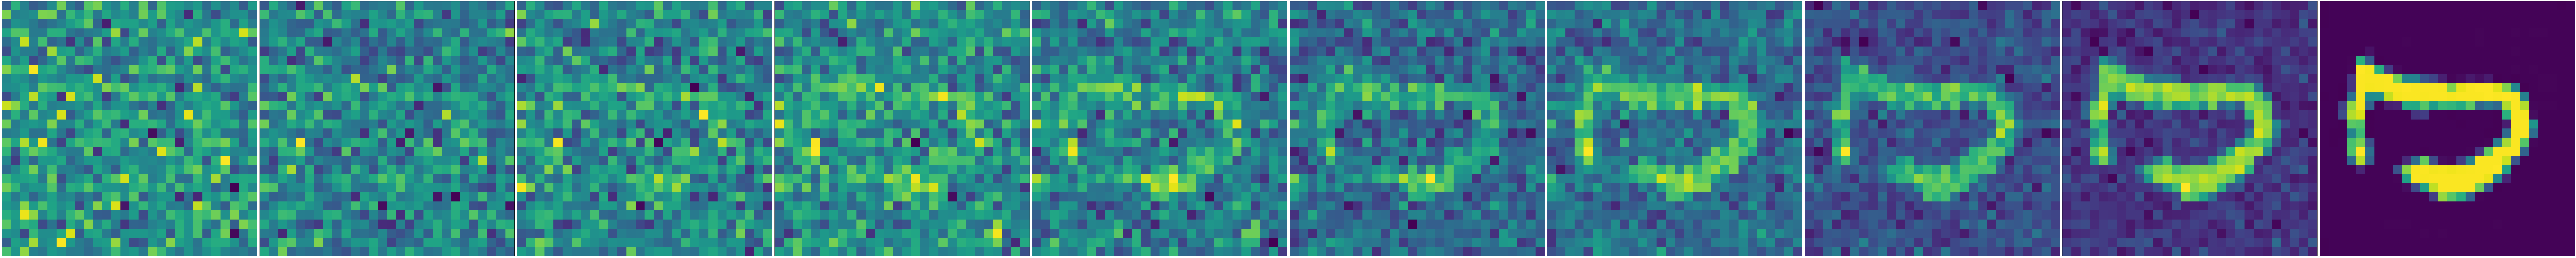

In [54]:
ims = diff_unet.sample(unet, height, batch_size=1)

# get 10 images from ims linearly spaced from 0 to T
idxs = torch.linspace(0, T-1, 10).int()

row_plot([ims[i].cpu().view(1, height, width) for i in idxs])

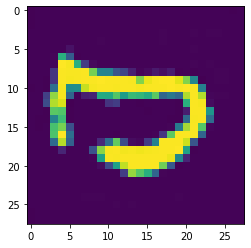

In [55]:
import matplotlib.pyplot as plt
plt.imshow(ims[-1].cpu().view(height, width));

In [56]:
# Model checkpointing
torch.save(unet.state_dict(), 'saved/mnist_unet.pt')

In [57]:
# https://wandb.ai/wandb/arttest/reports/Guide-to-W-B-Artifacts--VmlldzozNTAzMDM

MODEL_NAME = 'mnist_unet_test'

model_cpt_artifact = wandb.Artifact(
    MODEL_NAME, type="model",
    description="test save of mnist unet",
    metadata=args
)

model_cpt_artifact.add_dir("saved")

run.log_artifact(model_cpt_artifact)

wandb: Adding directory to artifact (./saved)... Done. 0.1s
